In [1]:
from datetime import datetime, timedelta
import time
import gc
import numpy as np
import pandas as pd
import lightgbm as lgb
import swifter # quick pandas.apply
pd.options.display.max_columns = 50

import sys 
sys.path.append("../codes")
from load_data import create_dt, reduce_mem_usage

> This notebook aims to push the public LB under 0.50. Certainly, the competition is not yet at its peak and there clearly remains room for improvement.

In [17]:
CAL_DTYPES={
    "event_name_1": "category", 
    "event_name_2": "category", 
    "event_type_1": "category", 
    "event_type_2": "category", 
    "weekday": "category", 
    'wm_yr_wk': 'int16', 
    "wday": "int16",
    "month": "int16", 
    "year": "int16", 
    "snap_CA": "int8", 
    'snap_TX': 'int8', 
    'snap_WI': 'int8' }

PRICE_DTYPES = {
    "store_id": "category", 
    "item_id": "category", 
    "wm_yr_wk": "int16",
    "sell_price":"float32" }

PATH_PRICE_CSV = "../input/m5-forecasting-accuracy/sell_prices.csv"
PATH_CALENDER_CSV = "../input/m5-forecasting-accuracy/calendar.csv"
PATH_SALES_CSV = "../input/m5-forecasting-accuracy/sales_train_validation.csv"
PATH_SALES_PUBLIC_CSV = "../input/m5-forecasting-accuracy/sales_train_evaluation.csv"

In [5]:
sales_train_val = pd.read_csv(PATH_SALES_CSV)
NUM_ITEMS = sales_train_val.shape[0]
print(NUM_ITEMS)
product = sales_train_val[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()


30490


In [16]:
for path in [PATH_PRICE_CSV, PATH_CALENDER_CSV, PATH_SALES_CSV,PATH_SALES_PUBLIC_CSV]:
    df = pd.read_csv(path)
    for c in df.columns:
        print(c, df[c].dtype)
#     print(df.describe())
#     display(df.head(3))
#     print(df.shape)

store_id object
item_id object
wm_yr_wk int64
sell_price float64
date object
wm_yr_wk int64
weekday object
wday int64
month int64
year int64
d object
event_name_1 object
event_type_1 object
event_name_2 object
event_type_2 object
snap_CA int64
snap_TX int64
snap_WI int64
id object
item_id object
dept_id object
cat_id object
store_id object
state_id object
d_1 int64
d_2 int64
d_3 int64
d_4 int64
d_5 int64
d_6 int64
d_7 int64
d_8 int64
d_9 int64
d_10 int64
d_11 int64
d_12 int64
d_13 int64
d_14 int64
d_15 int64
d_16 int64
d_17 int64
d_18 int64
d_19 int64
d_20 int64
d_21 int64
d_22 int64
d_23 int64
d_24 int64
d_25 int64
d_26 int64
d_27 int64
d_28 int64
d_29 int64
d_30 int64
d_31 int64
d_32 int64
d_33 int64
d_34 int64
d_35 int64
d_36 int64
d_37 int64
d_38 int64
d_39 int64
d_40 int64
d_41 int64
d_42 int64
d_43 int64
d_44 int64
d_45 int64
d_46 int64
d_47 int64
d_48 int64
d_49 int64
d_50 int64
d_51 int64
d_52 int64
d_53 int64
d_54 int64
d_55 int64
d_56 int64
d_57 int64
d_58 int64
d_59 int64
d_

d_897 int64
d_898 int64
d_899 int64
d_900 int64
d_901 int64
d_902 int64
d_903 int64
d_904 int64
d_905 int64
d_906 int64
d_907 int64
d_908 int64
d_909 int64
d_910 int64
d_911 int64
d_912 int64
d_913 int64
d_914 int64
d_915 int64
d_916 int64
d_917 int64
d_918 int64
d_919 int64
d_920 int64
d_921 int64
d_922 int64
d_923 int64
d_924 int64
d_925 int64
d_926 int64
d_927 int64
d_928 int64
d_929 int64
d_930 int64
d_931 int64
d_932 int64
d_933 int64
d_934 int64
d_935 int64
d_936 int64
d_937 int64
d_938 int64
d_939 int64
d_940 int64
d_941 int64
d_942 int64
d_943 int64
d_944 int64
d_945 int64
d_946 int64
d_947 int64
d_948 int64
d_949 int64
d_950 int64
d_951 int64
d_952 int64
d_953 int64
d_954 int64
d_955 int64
d_956 int64
d_957 int64
d_958 int64
d_959 int64
d_960 int64
d_961 int64
d_962 int64
d_963 int64
d_964 int64
d_965 int64
d_966 int64
d_967 int64
d_968 int64
d_969 int64
d_970 int64
d_971 int64
d_972 int64
d_973 int64
d_974 int64
d_975 int64
d_976 int64
d_977 int64
d_978 int64
d_979 int64
d_98

d_1646 int64
d_1647 int64
d_1648 int64
d_1649 int64
d_1650 int64
d_1651 int64
d_1652 int64
d_1653 int64
d_1654 int64
d_1655 int64
d_1656 int64
d_1657 int64
d_1658 int64
d_1659 int64
d_1660 int64
d_1661 int64
d_1662 int64
d_1663 int64
d_1664 int64
d_1665 int64
d_1666 int64
d_1667 int64
d_1668 int64
d_1669 int64
d_1670 int64
d_1671 int64
d_1672 int64
d_1673 int64
d_1674 int64
d_1675 int64
d_1676 int64
d_1677 int64
d_1678 int64
d_1679 int64
d_1680 int64
d_1681 int64
d_1682 int64
d_1683 int64
d_1684 int64
d_1685 int64
d_1686 int64
d_1687 int64
d_1688 int64
d_1689 int64
d_1690 int64
d_1691 int64
d_1692 int64
d_1693 int64
d_1694 int64
d_1695 int64
d_1696 int64
d_1697 int64
d_1698 int64
d_1699 int64
d_1700 int64
d_1701 int64
d_1702 int64
d_1703 int64
d_1704 int64
d_1705 int64
d_1706 int64
d_1707 int64
d_1708 int64
d_1709 int64
d_1710 int64
d_1711 int64
d_1712 int64
d_1713 int64
d_1714 int64
d_1715 int64
d_1716 int64
d_1717 int64
d_1718 int64
d_1719 int64
d_1720 int64
d_1721 int64
d_1722 int64

d_740 int64
d_741 int64
d_742 int64
d_743 int64
d_744 int64
d_745 int64
d_746 int64
d_747 int64
d_748 int64
d_749 int64
d_750 int64
d_751 int64
d_752 int64
d_753 int64
d_754 int64
d_755 int64
d_756 int64
d_757 int64
d_758 int64
d_759 int64
d_760 int64
d_761 int64
d_762 int64
d_763 int64
d_764 int64
d_765 int64
d_766 int64
d_767 int64
d_768 int64
d_769 int64
d_770 int64
d_771 int64
d_772 int64
d_773 int64
d_774 int64
d_775 int64
d_776 int64
d_777 int64
d_778 int64
d_779 int64
d_780 int64
d_781 int64
d_782 int64
d_783 int64
d_784 int64
d_785 int64
d_786 int64
d_787 int64
d_788 int64
d_789 int64
d_790 int64
d_791 int64
d_792 int64
d_793 int64
d_794 int64
d_795 int64
d_796 int64
d_797 int64
d_798 int64
d_799 int64
d_800 int64
d_801 int64
d_802 int64
d_803 int64
d_804 int64
d_805 int64
d_806 int64
d_807 int64
d_808 int64
d_809 int64
d_810 int64
d_811 int64
d_812 int64
d_813 int64
d_814 int64
d_815 int64
d_816 int64
d_817 int64
d_818 int64
d_819 int64
d_820 int64
d_821 int64
d_822 int64
d_82

d_1477 int64
d_1478 int64
d_1479 int64
d_1480 int64
d_1481 int64
d_1482 int64
d_1483 int64
d_1484 int64
d_1485 int64
d_1486 int64
d_1487 int64
d_1488 int64
d_1489 int64
d_1490 int64
d_1491 int64
d_1492 int64
d_1493 int64
d_1494 int64
d_1495 int64
d_1496 int64
d_1497 int64
d_1498 int64
d_1499 int64
d_1500 int64
d_1501 int64
d_1502 int64
d_1503 int64
d_1504 int64
d_1505 int64
d_1506 int64
d_1507 int64
d_1508 int64
d_1509 int64
d_1510 int64
d_1511 int64
d_1512 int64
d_1513 int64
d_1514 int64
d_1515 int64
d_1516 int64
d_1517 int64
d_1518 int64
d_1519 int64
d_1520 int64
d_1521 int64
d_1522 int64
d_1523 int64
d_1524 int64
d_1525 int64
d_1526 int64
d_1527 int64
d_1528 int64
d_1529 int64
d_1530 int64
d_1531 int64
d_1532 int64
d_1533 int64
d_1534 int64
d_1535 int64
d_1536 int64
d_1537 int64
d_1538 int64
d_1539 int64
d_1540 int64
d_1541 int64
d_1542 int64
d_1543 int64
d_1544 int64
d_1545 int64
d_1546 int64
d_1547 int64
d_1548 int64
d_1549 int64
d_1550 int64
d_1551 int64
d_1552 int64
d_1553 int64

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [5]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [6]:
h = 28 
max_lags = 60
tr_last = 1913

# start date where public lb and private lb are calculated
fday = datetime(2016,4, 25) 
seed = 46

dev_firstdate = fday - timedelta(tr_last - FIRST_DAY)
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [8]:
%%time
# df = create_dt(is_train=True, first_day=FIRST_DAY)
df.shape


CPU times: user 1h 35min 6s, sys: 5min 46s, total: 1h 40min 53s
Wall time: 1h 43min 34s


(46027957, 23)

In [9]:
# df.to_csv("../input/original_features.csv")

In [38]:
df = pd.read_csv("../input/original_features.csv", index_col=0)

KeyboardInterrupt: 

In [ ]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df = reduce_mem_usage(df)

In [401]:
for c in df.columns:
    print(c, df[c].dtype, type(df[c].iloc[0]))

id object <class 'str'>
item_id int16 <class 'numpy.int16'>
dept_id int16 <class 'numpy.int16'>
store_id int16 <class 'numpy.int16'>
cat_id int16 <class 'numpy.int16'>
state_id int16 <class 'numpy.int16'>
d object <class 'str'>
sales float32 <class 'numpy.float32'>
date datetime64[ns] <class 'pandas._libs.tslibs.timestamps.Timestamp'>
wm_yr_wk int16 <class 'numpy.int16'>
weekday int16 <class 'numpy.int16'>
wday int16 <class 'numpy.int16'>
month int16 <class 'numpy.int16'>
year int16 <class 'numpy.int16'>
event_name_1 int16 <class 'numpy.int16'>
event_type_1 int16 <class 'numpy.int16'>
event_name_2 int16 <class 'numpy.int16'>
event_type_2 int16 <class 'numpy.int16'>
snap_CA float32 <class 'numpy.float32'>
snap_TX float32 <class 'numpy.float32'>
snap_WI float32 <class 'numpy.float32'>
sell_price float32 <class 'numpy.float32'>
snap_flag float64 <class 'numpy.float64'>


In [352]:
display(df.head())
display(df.tail())

,id,item_id,dept_id,store_id,cat_id,state_id,state_name,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,snap_flag
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,CA,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,0.0
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,CA,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,0.0
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,CA,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,0.0
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,CA,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.46,1.0
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,CA,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.46,1.0


,id,item_id,dept_id,store_id,cat_id,state_id,state_name,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,snap_flag
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,WI,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,WI,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0
46027954,FOODS_3_826_WI_3_validation,3047,6,9,2,2,WI,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0
46027955,FOODS_3_827_WI_3_validation,3048,6,9,2,2,WI,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0
46027956,FOODS_3_827_WI_3_validation,3048,6,9,2,2,WI,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0


> For the validation rows, this corresponds to d_1914 - d_1941, and for the evaluation rows, this corresponds to d_1942 - d_1969

from https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation

In [27]:
def create_fea(dt, cash_df=None, start_date=None):
    # start_date: start date to create features from.
    
    useless_cols = []

#     lags = [7, 28]
    lags = [2, 5, 7, 28]

    lag_about = ["id","item_id", "dept_id", "cat_id", "store_id", "state_id"]
    today_sale_cols = []

    for col in lag_about:
        if col == "id":
            continue
        dt[f"d_{col}"] = dt["d"].astype(str) + "_" + dt[col].astype(str)
        dt[f"today_{col}_mean"] = dt[["sales", f"d_{col}"]].groupby([f"d_{col}"])["sales"].transform("mean")
        today_sale_cols.append(f"today_{col}_mean")

        useless_cols.append(f"today_{col}_mean"); useless_cols.append(f"d_{col}"); 

    lag_cols = []
    lag_saver = []
    lag_features = []

    for lag in lags:
        for feature in lag_about:
            lag_cols.append(f"salelag_{lag}_{feature}")
            lag_saver.append(lag)
            lag_features.append(feature)

    for lag, lag_col, f in zip(lag_saver, lag_cols, lag_features):
        if f == "id":
            dt[lag_col] = dt[["id", "sales"]].groupby("id")["sales"].shift(lag)
        else:
            dt[lag_col] = dt[["id", f"today_{f}_mean"]].groupby("id")[f"today_{f}_mean"].shift(lag)

#     wins = [7, 28]
        wins = [3, 7, 14, 28]
    for win in wins :
        for lag, lag_col in zip(lag_saver, lag_cols):
#             print(f"Making rolling features. lag_col:{lag_col} lag:{lag} window:{win}")
            dt[f"rmean_{lag_col}_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
#             dt[f"rmedian_{lag_col}_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).median())

    date_features = {  
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

    for col in useless_cols:
        del dt[col]
    gc.collect()



In [28]:
%%time
# creating features
create_fea(df)
df.shape

CPU times: user 1h 26min 41s, sys: 1h 35min 29s, total: 3h 2min 10s
Wall time: 4h 16min 58s


(46027957, 146)

In [49]:
for c in df.columns:
    print(c, df[c].dtype, type(df[c].iloc[0]))

id object <class 'str'>
item_id int16 <class 'numpy.int16'>
dept_id int16 <class 'numpy.int16'>
store_id int16 <class 'numpy.int16'>
cat_id int16 <class 'numpy.int16'>
state_id int16 <class 'numpy.int16'>
d object <class 'str'>
sales float32 <class 'numpy.float32'>
date datetime64[ns] <class 'pandas._libs.tslibs.timestamps.Timestamp'>
wm_yr_wk int16 <class 'numpy.int16'>
weekday int16 <class 'numpy.int16'>
wday int16 <class 'numpy.int16'>
month int16 <class 'numpy.int16'>
year int16 <class 'numpy.int16'>
event_name_1 int16 <class 'numpy.int16'>
event_type_1 int16 <class 'numpy.int16'>
event_name_2 int16 <class 'numpy.int16'>
event_type_2 int16 <class 'numpy.int16'>
snap_CA float32 <class 'numpy.float32'>
snap_TX float32 <class 'numpy.float32'>
snap_WI float32 <class 'numpy.float32'>
sell_price float32 <class 'numpy.float32'>
snap_flag float64 <class 'numpy.float64'>


In [12]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 21208.64 MB
Memory usage after optimization is: 11990.55 MB
Decreased by 43.5%


In [29]:
df.to_csv("../input/processed_features_startwith1_all_te_lags_1_3_7_28_wins_3_7_14_28.csv")

In [8]:
# df = pd.read_csv("../input/processed_features_startwith1500.csv", index_col=0)
df = pd.read_csv("../input/processed_features_startwith1_te.csv", index_col=0)

In [30]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 13563.77 MB
Memory usage after optimization is: 13344.29 MB
Decreased by 1.6%


In [7]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,snap_flag,salelag_1_id,salelag_1_item_id,...,rmean_salelag_28_dept_id_28_14,rmean_salelag_28_cat_id_28_14,rmean_salelag_28_store_id_28_14,rmean_salelag_28_state_id_28_14,rmean_salelag_1_id_1_28,rmean_salelag_1_item_id_1_28,rmean_salelag_1_dept_id_1_28,rmean_salelag_1_cat_id_1_28,rmean_salelag_1_store_id_1_28,rmean_salelag_1_state_id_1_28,rmean_salelag_7_id_7_28,rmean_salelag_7_item_id_7_28,rmean_salelag_7_dept_id_7_28,rmean_salelag_7_cat_id_7_28,rmean_salelag_7_store_id_7_28,rmean_salelag_7_state_id_7_28,rmean_salelag_28_id_28_28,rmean_salelag_28_item_id_28_28,rmean_salelag_28_dept_id_28_28,rmean_salelag_28_cat_id_28_28,rmean_salelag_28_store_id_28_28,rmean_salelag_28_state_id_28_28,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,0.0,12.0,8.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.46,0.0,15.0,6.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.46,1.0,0.0,7.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.46,1.0,0.0,5.750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2


In [ ]:
df.memory_usage().sum() / 1024**2

In [8]:
part = df.iloc[-5000:]

In [9]:
part[["sales", "cat_id", "state_id", "d"]].groupby(["cat_id","state_id", "d"]).mean()

sales
cat_id state_id d               
0      2        d_1912  0.187500
                d_1913  0.000000
1      2        d_1912  0.986628
                d_1913  0.923591
2      2        d_1912  2.254697
                d_1913  2.162143

In [53]:
for c in df.columns:
    print(c, df[c].dtype, type(df[c].iloc[0]))

id object <class 'str'>
item_id int16 <class 'numpy.int16'>
dept_id int8 <class 'numpy.int8'>
store_id int8 <class 'numpy.int8'>
cat_id int8 <class 'numpy.int8'>
state_id int8 <class 'numpy.int8'>
d object <class 'str'>
sales float16 <class 'numpy.float16'>
date datetime64[ns] <class 'pandas._libs.tslibs.timestamps.Timestamp'>
wm_yr_wk int16 <class 'numpy.int16'>
weekday int8 <class 'numpy.int8'>
wday int8 <class 'numpy.int8'>
month int8 <class 'numpy.int8'>
year int16 <class 'numpy.int16'>
event_name_1 int8 <class 'numpy.int8'>
event_type_1 int8 <class 'numpy.int8'>
event_name_2 int8 <class 'numpy.int8'>
event_type_2 int8 <class 'numpy.int8'>
snap_CA float16 <class 'numpy.float16'>
snap_TX float16 <class 'numpy.float16'>
snap_WI float16 <class 'numpy.float16'>
sell_price float16 <class 'numpy.float16'>
snap_flag float16 <class 'numpy.float16'>


In [31]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id']
cat_feats.extend(["event_name_1", "event_name_2", 
                  "event_type_1", "event_type_2",
                  "wday", "month", "year",
                  "snap_flag"])
useless_cols = ["id", "date", "sales","d", 
                "wm_yr_wk", "weekday",
               "state_name", "snap_CA", "snap_TX", "snap_WI"]
# X_train = df[train_cols]
# y_train = df["sales"]

In [32]:
for c in df.columns[~df.columns.isin(useless_cols)] :
    print(c)

item_id
dept_id
store_id
cat_id
state_id
wday
month
year
event_name_1
event_type_1
event_name_2
event_type_2
sell_price
snap_flag
salelag_1_id
salelag_1_item_id
salelag_1_dept_id
salelag_1_cat_id
salelag_1_store_id
salelag_1_state_id
salelag_3_id
salelag_3_item_id
salelag_3_dept_id
salelag_3_cat_id
salelag_3_store_id
salelag_3_state_id
salelag_7_id
salelag_7_item_id
salelag_7_dept_id
salelag_7_cat_id
salelag_7_store_id
salelag_7_state_id
salelag_28_id
salelag_28_item_id
salelag_28_dept_id
salelag_28_cat_id
salelag_28_store_id
salelag_28_state_id
rmean_salelag_1_id_1_3
rmean_salelag_1_item_id_1_3
rmean_salelag_1_dept_id_1_3
rmean_salelag_1_cat_id_1_3
rmean_salelag_1_store_id_1_3
rmean_salelag_1_state_id_1_3
rmean_salelag_3_id_3_3
rmean_salelag_3_item_id_3_3
rmean_salelag_3_dept_id_3_3
rmean_salelag_3_cat_id_3_3
rmean_salelag_3_store_id_3_3
rmean_salelag_3_state_id_3_3
rmean_salelag_7_id_7_3
rmean_salelag_7_item_id_7_3
rmean_salelag_7_dept_id_7_3
rmean_salelag_7_cat_id_7_3
rmean_salelag_

In [16]:
# define wrmsse

from scipy.sparse import csr_matrix

weight_mat = np.c_[np.ones([NUM_ITEMS,1]).astype(np.int8), # level 1
                   pd.get_dummies(product.state_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str) + product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str) + product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.item_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.item_id.astype(str),drop_first=False).astype('int8').values,
                   np.identity(NUM_ITEMS).astype(np.int8) #item :level 12
                   ].T

weight_mat_csr = csr_matrix(weight_mat)
del weight_mat; gc.collect()

def weight_calc(data,product):
    
    # calculate the denominator of RMSSE, and calculate the weight base on sales amount

    sales_train_val = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')

    d_name = ['d_' + str(i+1) for i in range(1913)]

    sales_train_val = weight_mat_csr * sales_train_val[d_name].values

    # calculate the start position(first non-zero demand observed date) for each item / 商品の最初の売上日
    # 1-1914のdayの数列のうち, 売上が存在しない日を一旦0にし、0を9999に置換。そのうえでminimum numberを計算
    df_tmp = ((sales_train_val>0) * np.tile(np.arange(1,1914),(weight_mat_csr.shape[0],1)))

    start_no = np.min(np.where(df_tmp==0,9999,df_tmp),axis=1)-1

    flag = np.dot(np.diag(1/(start_no+1)) , np.tile(np.arange(1,1914),(weight_mat_csr.shape[0],1)))<1

    sales_train_val = np.where(flag,np.nan,sales_train_val)

    # denominator of RMSSE / RMSSEの分母
    weight1 = np.nansum(np.diff(sales_train_val,axis=1)**2,axis=1)/(1913-start_no)

    # calculate the sales amount for each item/level
    df_tmp = data[(data['date'] >= '2016-03-25') & (data['date'] <= '2016-04-24')]
    df_tmp['amount'] = df_tmp['sales'] * df_tmp['sell_price']
    df_tmp =df_tmp.groupby(['id'])['amount'].apply(np.sum)
    df_tmp = df_tmp[product.id].values
    
    weight2 = weight_mat_csr * df_tmp 

    weight2 = weight2/np.sum(weight2)

    del sales_train_val
    gc.collect()
    
    return weight1, weight2

weight1, weight2 = weight_calc(df, product)

/Users/daiki/.local/share/virtualenvs/kaggle_m5-zmPcSgfy/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
DAYS_PRED = 28

def wrmsse(preds, data):
    
    # this function is calculate for last 28 days to consider the non-zero demand period
    
    # actual obserbed values / 正解ラベル
    y_true = data.get_label()
    
    y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
    preds = preds[-(NUM_ITEMS * DAYS_PRED):]
    # number of columns
    num_col = DAYS_PRED
    
    # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) ) / 推論の結果が 1 次元の配列になっているので直す
    reshaped_preds = preds.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
    
          
    train = weight_mat_csr*np.c_[reshaped_preds, reshaped_true]
    
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,:num_col] - train[:,num_col:])
                        ,axis=1) / weight1) * weight2)
    
    return 'wrmsse', score, False

def wrmsse_simple(preds, data):
    
    # actual obserbed values / 正解ラベル
    y_true = data.get_label()
    
    y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
    preds = preds[-(NUM_ITEMS * DAYS_PRED):]
    # number of columns
    num_col = DAYS_PRED
    
    # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) ) / 推論の結果が 1 次元の配列になっているので直す
    reshaped_preds = preds.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
          
    train = np.c_[reshaped_preds, reshaped_true]
    
    weight2_2 = weight2[:NUM_ITEMS]
    weight2_2 = weight2_2/np.sum(weight2_2)
    
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,:num_col] - train[:,num_col:])
                        ,axis=1) /  weight1[:NUM_ITEMS])*weight2_2)
    
    return 'wrmsse', score, False

In [18]:
params = {
        "objective" : "tweedie",
        'tweedie_variance_power': 1.1,
        "metric" : ["custom", "rmse"],
        "learning_rate" : 0.08,
        "feature_fraction": 0.6,
        "bagging_fraction" : 0.85,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'num_leaves': 70,
#         'num_leaves': 30,
        "min_data_in_leaf": 100,
        "max_depth" : 7,
#         "max_depth" : 6,
        "num_threads": 8,
}

In [33]:
# train_validation split
val_days = 27
n_folds = 1
dev_lastdate = datetime(2016,4, 24)

# target_encoding_periods = [7, 27]

for fold_idx in range(1, 1+n_folds, 1):
    print("*"*20)
    print(f"fold {fold_idx}...")
    print("*"*20)

    val_firstdate = dev_lastdate - timedelta(days=val_days*fold_idx)
    val_lastdate = dev_lastdate - timedelta(days=val_days*(fold_idx-1))
    train_lastdate = val_firstdate-timedelta(1)

    print("train period:", dev_firstdate.date(), "~", train_lastdate.date())
    print("validation period:", val_firstdate.date(), "~", val_lastdate.date())

    train_df = df.query("date < @val_firstdate")
    val_df = df.query("@val_lastdate >= date > @train_lastdate")
    
    del df; gc.collect();

    print(min(train_df["date"]), max(train_df["date"]))
    print(min(val_df["date"]), max(val_df["date"]))
    
#     for col in ["item_id", "dept_id", "cat_id", "store_id", "state_id"]:
#         # target encoding
#         print(f"Target encoding {col}")

#         for target_encoding_period in target_encoding_periods:
#             train_df[col+f"_sales_mean_{target_encoding_period}"] = np.nan
        
#             for i in range((train_lastdate - dev_firstdate).days // target_encoding_period + 1):
#                 period_start = train_lastdate - timedelta(days=target_encoding_period*(1+i))
#                 period_last = train_lastdate - timedelta(days=target_encoding_period*(i))
                
#                 te_period_start = train_lastdate - timedelta(days=target_encoding_period*(2+i))
#                 te_period_last = period_start - timedelta(1)
#                 te_df = train_df.query("@te_period_last >= date >= @te_period_start").copy()
#                 target = train_df.loc[(period_start <= train_df.date) & (train_df.date <= period_last)].copy()
#                 train_df.loc[(period_start <= train_df.date) & (train_df.date <= period_last), col+f"_sales_mean_{target_encoding_period}"] = target[col].map(te_df.groupby(col)["sales"].mean())
            
#         train_df[col+"_sales_mean"] = train_df.groupby(col)["sales"].transform('mean')
#         val_df[col + '_sales_mean'] = val_df[col].map(train_df.groupby(col)['sales'].mean())
        
#             val_te_date = val_firstdate-timedelta(days=target_encoding_period)
#             val_df[col + f'_sales_mean_{target_encoding_period}'] = val_df[col].map(train_df.query("@train_lastdate >= date >= @val_te_date").groupby(col)['sales'].mean())

    train_df[:1000].dropna(inplace=True)
    train_cols = train_df.columns[~train_df.columns.isin(useless_cols)] 
    print(train_cols)
    
    train_data = lgb.Dataset(train_df[train_cols], 
                             label = train_df["sales"], 
                             free_raw_data=False)
    val_data = lgb.Dataset(val_df[train_cols], 
                             label = val_df["sales"], 
                             free_raw_data=False)

    del train_df, val_df; gc.collect()

    m_lgb = lgb.train(params, 
                      train_data, 
                      valid_sets = [train_data, val_data], 
                      num_boost_round=2500,
                      early_stopping_rounds=500,
                      categorical_feature=cat_feats,
                      verbose_eval=100,
                      feval=wrmsse) 
#     m_lgb.save_model(f"../result/targetencoding_fullmodel_fold{fold_idx}.lgb")
    m_lgb.save_model(f"../result/targetencoding_lag_1_3_7_28_win_3_7_14_28_fullmodel_fold{fold_idx}.lgb")

********************
fold 1...
********************
train period: 2011-01-30 ~ 2016-03-27
validation period: 2016-03-28 ~ 2016-04-24
2011-01-29 00:00:00 2016-03-27 00:00:00
2016-03-28 00:00:00 2016-04-24 00:00:00
Index(['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1',
       ...
       'rmean_salelag_7_state_id_7_28', 'rmean_salelag_28_id_28_28',
       'rmean_salelag_28_item_id_28_28', 'rmean_salelag_28_dept_id_28_28',
       'rmean_salelag_28_cat_id_28_28', 'rmean_salelag_28_store_id_28_28',
       'rmean_salelag_28_state_id_28_28', 'week', 'quarter', 'mday'],
      dtype='object', length=137)


/Users/daiki/.local/share/virtualenvs/kaggle_m5-zmPcSgfy/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/daiki/.local/share/virtualenvs/kaggle_m5-zmPcSgfy/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'item_id', 'month', 'snap_flag', 'state_id', 'store_id', 'wday', 'year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 2.2297	training's wrmsse: 0.473275	valid_1's rmse: 1.90141	valid_1's wrmsse: 0.456114
[200]	training's rmse: 2.20484	training's wrmsse: 0.447204	valid_1's rmse: 1.89415	valid_1's wrmsse: 0.436175
[300]	training's rmse: 2.18657	training's wrmsse: 0.433638	valid_1's rmse: 1.88998	valid_1's wrmsse: 0.426389
[400]	training's rmse: 2.17402	training's wrmsse: 0.420173	valid_1's rmse: 1.88753	valid_1's wrmsse: 0.422977
[500]	training's rmse: 2.1609	training's wrmsse: 0.415011	valid_1's rmse: 1.88608	valid_1's wrmsse: 0.422899
[600]	training's rmse: 2.14987	training's wrmsse: 0.40565	valid_1's rmse: 1.88351	valid_1's wrmsse: 0.421489
[700]	training's rmse: 2.14143	training's wrmsse: 0.400092	valid_1's rmse: 1.88205	valid_1's wrmsse: 0.418862
[800]	training's rmse: 2.13507	training's wrmsse: 0.396273	valid_1's rmse: 1.88144	valid_1's wrmsse: 0.418182
[900]	training's rmse: 2.12923	training's wrmsse: 0.394405	va

In [34]:
importance = pd.DataFrame(m_lgb.feature_importance(), index=train_cols, columns=['importance']).sort_values("importance",inplace=False,ascending=False)
display(importance.iloc[:20])

,importance
item_id,17420
store_id,3976
event_name_1,3846
month,3214
rmean_salelag_1_id_1_3,2954
salelag_1_id,2779
wday,2532
salelag_1_item_id,2406
rmean_salelag_1_id_1_7,2142
sell_price,1937


In [23]:
m_lgb.save_model(f"../result/targetencoding_lag_3_7_28_win_3_7_14_28_fullmodel_fold1.lgb")

In [313]:
# dt[["id", lag_col]].groupby("id")[lag_col]
# part.groupby(["id"]).mean()

m = part[["sales","d_store_id"]].groupby(["d_store_id"]).mean()

In [314]:
m

,sales
d_store_id,
d_1877_8,1.965820
d_1877_9,1.555664
d_1878_8,2.126953
d_1878_9,1.416016
d_1879_8,1.701172
d_1879_9,1.014648
d_1880_8,1.527344
d_1880_9,0.973145
d_1881_8,1.469727


In [292]:
m.loc[datetime(2016,3,19),0]

sales    0.0
Name: (2016-03-19 00:00:00, 0), dtype: float16

In [310]:
for col in ["item_id", "dept_id", "store_id", "cat_id"]:
    part[f"d_{col}"] = part["d"].astype(str) + "_" + part[col].astype(str)

/Users/daiki/.local/share/virtualenvs/kaggle_m5-zmPcSgfy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [311]:
part

,id,item_id,dept_id,store_id,cat_id,state_id,state_name,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,...,rmedian_1_7,rmean_7_7,rmedian_7_7,rmean_28_7,rmedian_28_7,rmean_1_14,rmedian_1_14,rmean_7_14,rmedian_7_14,rmean_28_14,rmedian_28_14,rmean_1_28,rmedian_1_28,rmean_7_28,rmedian_7_28,rmean_28_28,rmedian_28_28,week,quarter,mday,snap_flag,d_item_id,d_dept_id,d_store_id,d_cat_id
45074237,HOBBIES_2_108_WI_2_validation,523,1,8,0,2,WI,d_1882,0.0,2016-03-24,11608,4,6,3,2016,24,3,0,0,0.0,0.0,0.0,2.970703,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.142822,0.0,0.071411,0.0,0.107117,0.0,0.107117,0.0,0.107117,0.0,12,1,24,0.0,d_1882_523,d_1882_1,d_1882_8,d_1882_0
45074238,HOBBIES_2_108_WI_2_validation,523,1,8,0,2,WI,d_1883,0.0,2016-03-25,11608,0,7,3,2016,0,0,0,0,0.0,0.0,0.0,2.970703,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.142822,0.0,0.071411,0.0,0.107117,0.0,0.107117,0.0,0.107117,0.0,12,1,25,0.0,d_1883_523,d_1883_1,d_1883_8,d_1883_0
45074239,HOBBIES_2_109_WI_2_validation,524,1,8,0,2,WI,d_1877,0.0,2016-03-19,11608,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,0.970215,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.142822,0.0,0.000000,0.0,0.071411,0.0,0.071411,0.0,0.071411,0.0,11,1,19,0.0,d_1877_524,d_1877_1,d_1877_8,d_1877_0
45074240,HOBBIES_2_109_WI_2_validation,524,1,8,0,2,WI,d_1878,0.0,2016-03-20,11608,3,2,3,2016,0,0,0,0,0.0,0.0,0.0,0.970215,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.142822,0.0,0.000000,0.0,0.071411,0.0,0.071411,0.0,0.071411,0.0,11,1,20,0.0,d_1878_524,d_1878_1,d_1878_8,d_1878_0
45074241,HOBBIES_2_109_WI_2_validation,524,1,8,0,2,WI,d_1879,0.0,2016-03-21,11608,1,3,3,2016,0,0,0,0,0.0,0.0,0.0,0.970215,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.071411,0.0,0.000000,0.0,0.071411,0.0,0.071411,0.0,0.071411,0.0,12,1,21,0.0,d_1879_524,d_1879_1,d_1879_8,d_1879_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45326667,FOODS_3_825_WI_3_validation,3046,6,9,2,2,WI,d_1885,1.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,3.980469,0.0,0.0,...,0.0,1.000000,1.0,0.428467,0.0,0.856934,0.5,1.213867,1.0,0.500000,0.0,1.213867,1.0,1.178711,1.0,0.643066,0.5,12,1,27,0.0,d_1885_3046,d_1885_6,d_1885_9,d_1885_2
45326673,FOODS_3_826_WI_3_validation,3047,6,9,2,2,WI,d_1884,2.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,1.0,...,1.0,1.428711,1.0,0.000000,0.0,1.213867,1.0,0.928711,1.0,0.785645,0.0,1.036133,1.0,0.821289,0.0,1.000000,0.5,12,1,26,0.0,d_1884_3047,d_1884_6,d_1884_9,d_1884_2
45326674,FOODS_3_826_WI_3_validation,3047,6,9,2,2,WI,d_1885,4.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,1.280273,2.0,1.0,...,1.0,1.142578,1.0,0.000000,0.0,1.286133,1.0,0.856934,1.0,0.643066,0.0,1.107422,1.0,0.856934,0.5,0.893066,0.0,12,1,27,0.0,d_1885_3047,d_1885_6,d_1885_9,d_1885_2
45326680,FOODS_3_827_WI_3_validation,3048,6,9,2,2,WI,d_1884,0.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.000000,2.0,1.0,...,2.0,2.142578,3.0,1.571289,1.0,2.357422,2.5,1.357422,1.0,1.357422,1.0,1.928711,2.0,1.607422,1.0,1.607422,1.0,12,1,26,0.0,d_1884_3048,d_1884_6,d_1884_9,d_1884_2


In [263]:
part[["state_id", "sales"]].groupby("state_id")["sales"].shift(1)

45323187    NaN
45323188    0.0
45323194    0.0
45323195    3.0
45323201    2.0
           ... 
45326667    0.0
45326673    1.0
45326674    2.0
45326680    4.0
45326681    0.0
Name: sales, Length: 1000, dtype: float16

In [214]:
train_df.loc[(period_start <= train_df.date) & (train_df.date <= period_last), col].map(te_df.groupby(col)["sales"].mean())

28880082    0.695801
28880083    0.695801
28880084    0.695801
28880085    0.695801
28880086    0.695801
              ...   
29697915    2.189453
29697916    2.189453
29697917    2.189453
29697918    2.189453
29697919    2.189453
Name: dept_id, Length: 817838, dtype: float16

In [208]:
i = 0
period_start = train_lastdate - timedelta(days=target_encoding_period*(1+i))
period_last = train_lastdate - timedelta(days=target_encoding_period*(i))
te_period_first = train_lastdate - timedelta(days=target_encoding_period*(2+i))
te_period_last = period_start - timedelta(1)
te_df = train_df.query("@te_period_last >= date >= @te_period_first")
train_df.loc[(period_start <= train_df.date) & (train_df.date <= period_last), :]

,id,item_id,dept_id,store_id,cat_id,state_id,state_name,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,...,rmedian_7_3,rmean_28_3,rmedian_28_3,rmean_1_7,rmedian_1_7,rmean_7_7,rmedian_7_7,rmean_28_7,rmedian_28_7,rmean_1_14,rmedian_1_14,rmean_7_14,rmedian_7_14,rmean_28_14,rmedian_28_14,rmean_1_28,rmedian_1_28,rmean_7_28,rmedian_7_28,rmean_28_28,rmedian_28_28,week,quarter,mday,snap_flag
44259539,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,CA,d_1858,0.0,2016-02-29,11605,1,3,2,2016,0,0,0,0,0.0,0.0,0.0,8.257812,2.0,4.0,...,2.0,0.666504,1.0,1.713867,1.0,1.142578,1.0,0.714355,1.0,1.142578,1.0,1.071289,0.5,0.785645,1.0,1.036133,1.0,0.893066,1.0,0.785645,0.0,9,1,29,0.0
44259540,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,CA,d_1859,2.0,2016-03-01,11605,5,4,3,2016,0,0,0,0,1.0,1.0,0.0,8.257812,0.0,0.0,...,0.0,1.000000,1.0,1.142578,1.0,1.142578,1.0,0.714355,1.0,1.142578,1.0,0.928711,0.0,0.714355,1.0,1.000000,1.0,0.856934,1.0,0.821289,0.5,9,1,1,1.0
44259541,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,CA,d_1860,0.0,2016-03-02,11605,6,5,3,2016,0,0,0,0,1.0,0.0,1.0,8.257812,2.0,1.0,...,1.0,1.000000,1.0,1.428711,1.0,1.286133,1.0,0.714355,1.0,1.286133,1.0,1.000000,0.5,0.714355,1.0,1.036133,1.0,0.856934,1.0,0.821289,0.5,9,1,2,1.0
44259542,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,CA,d_1861,1.0,2016-03-03,11605,4,6,3,2016,0,0,0,0,1.0,1.0,1.0,8.257812,0.0,0.0,...,0.0,1.000000,1.0,1.286133,1.0,1.142578,1.0,0.714355,1.0,1.286133,1.0,1.000000,0.5,0.643066,1.0,1.000000,0.5,0.821289,0.5,0.856934,1.0,9,1,3,1.0
44259543,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,CA,d_1862,1.0,2016-03-04,11605,0,7,3,2016,0,0,0,0,1.0,0.0,0.0,8.257812,1.0,1.0,...,1.0,0.666504,1.0,1.428711,1.0,1.142578,1.0,0.714355,1.0,1.286133,1.0,1.000000,0.5,0.571289,1.0,1.000000,0.5,0.856934,1.0,0.821289,0.5,9,1,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45326667,FOODS_3_825_WI_3_validation,3046,6,9,2,2,WI,d_1885,1.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,3.980469,0.0,0.0,...,0.0,0.666504,0.0,0.571289,0.0,1.000000,1.0,0.428467,0.0,0.856934,0.5,1.213867,1.0,0.500000,0.0,1.213867,1.0,1.178711,1.0,0.643066,0.5,12,1,27,0.0
45326673,FOODS_3_826_WI_3_validation,3047,6,9,2,2,WI,d_1884,2.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,1.0,...,1.0,0.000000,0.0,1.000000,1.0,1.428711,1.0,0.000000,0.0,1.213867,1.0,0.928711,1.0,0.785645,0.0,1.036133,1.0,0.821289,0.0,1.000000,0.5,12,1,26,0.0
45326674,FOODS_3_826_WI_3_validation,3047,6,9,2,2,WI,d_1885,4.0,2016-03-27,11609,3,2,3,2016,5,1,0,0,0.0,0.0,0.0,1.280273,2.0,1.0,...,1.0,0.000000,0.0,1.142578,1.0,1.142578,1.0,0.000000,0.0,1.286133,1.0,0.856934,1.0,0.643066,0.0,1.107422,1.0,0.856934,0.5,0.893066,0.0,12,1,27,0.0
45326680,FOODS_3_827_WI_3_validation,3048,6,9,2,2,WI,d_1884,0.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.000000,2.0,1.0,...,1.0,1.666992,1.0,2.427734,2.0,2.142578,3.0,1.571289,1.0,2.357422,2.5,1.357422,1.0,1.357422,1.0,1.928711,2.0,1.607422,1.0,1.607422,1.0,12,1,26,0.0


In [205]:
te_df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,state_name,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,...,rmedian_7_3,rmean_28_3,rmedian_28_3,rmean_1_7,rmedian_1_7,rmean_7_7,rmedian_7_7,rmean_28_7,rmedian_28_7,rmean_1_14,rmedian_1_14,rmean_7_14,rmedian_7_14,rmean_28_14,rmedian_28_14,rmean_1_28,rmedian_1_28,rmean_7_28,rmedian_7_28,rmean_28_28,rmedian_28_28,week,quarter,mday,snap_flag
43405932,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,CA,d_1831,1.0,2016-02-02,11601,5,4,2,2016,0,0,0,0,1.0,0.0,1.0,8.257812,1.0,1.0,...,0.0,1.000000,1.0,0.714355,1.0,0.714355,1.0,0.856934,1.0,0.785645,1.0,0.500000,0.0,0.856934,0.5,0.785645,0.0,0.856934,0.0,0.750000,0.0,5,1,2,1.0
43405933,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,CA,d_1832,1.0,2016-02-03,11601,6,5,2,2016,0,0,0,0,1.0,1.0,1.0,8.257812,1.0,1.0,...,1.0,1.000000,1.0,0.714355,1.0,0.714355,1.0,0.714355,1.0,0.714355,1.0,0.571289,0.0,0.714355,0.5,0.821289,0.5,0.821289,0.0,0.750000,0.0,5,1,3,1.0
43405934,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,CA,d_1833,1.0,2016-02-04,11601,4,6,2,2016,0,0,0,0,1.0,0.0,0.0,8.257812,1.0,1.0,...,1.0,0.333252,0.0,0.714355,1.0,0.571289,1.0,0.571289,0.0,0.714355,1.0,0.643066,0.5,0.714355,0.5,0.821289,0.5,0.821289,0.0,0.750000,0.0,5,1,4,1.0
43405935,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,CA,d_1834,0.0,2016-02-05,11601,0,7,2,2016,0,0,0,0,1.0,1.0,1.0,8.257812,1.0,0.0,...,1.0,0.666504,1.0,0.714355,1.0,0.428467,0.0,0.714355,1.0,0.643066,1.0,0.643066,0.5,0.785645,1.0,0.856934,1.0,0.821289,0.0,0.785645,0.5,5,1,5,1.0
43405939,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,CA,d_1831,0.0,2016-02-02,11601,5,4,2,2016,0,0,0,0,1.0,0.0,1.0,3.970703,1.0,0.0,...,0.0,0.000000,0.0,0.285645,0.0,0.000000,0.0,0.000000,0.0,0.142822,0.0,0.142822,0.0,0.643066,0.0,0.178589,0.0,0.107117,0.0,0.856934,0.0,5,1,2,1.0


In [35]:
%%time
# Infercence

print("max lags:", max_lags)

# devdf_for_te = df.query("date >= @val_first_date")

for idx in range(1, 1+n_folds, 1):
    m_lgb = lgb.Booster(model_file=f"../result/targetencoding_lag_1_3_7_28_win_3_7_14_28_fullmodel_fold{fold_idx}.lgb")
    # alphas = [1.028, 1.023, 1.018]
    alphas = [1.0]
    weights = [1/len(alphas)]*len(alphas)
    sub = 0.    

    for icount, (alpha, weight) in enumerate(zip(alphas, weights)):
        te = create_dt(False)
        cols = [f"F{i}" for i in range(1,29)]
        
        for tdelta in range(0, 28):
            start = time.time()
            # target date to predict sales
            day = fday + timedelta(days=tdelta)
            print("Predicting : ", tdelta, day.date())
            
            # target period
            tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
            create_fea(tst)
            
            tst = tst.loc[tst.date == day, train_cols]
            # fill "sales" with predicted value by model
            predictions = alpha*m_lgb.predict(tst) # magic multiplier by kyakovlev
            te.loc[te.date == day, "sales"] = predictions # magic multiplier by kyakovlev
            print(f"Elapsed time: {(time.time() - start) // 60} min.")
            
            
        te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
    #     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
    #                                                                           "id"].str.replace("validation$", "evaluation")
        te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
        te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
        te_sub.fillna(0., inplace = True)
        te_sub.sort_values("id", inplace = True)
        te_sub.reset_index(drop=True, inplace = True)
        te_sub.to_csv(f"../result/submission_{icount}.csv",index=False)
        if icount == 0 :
            sub = te_sub
            sub[cols] *= weight
        else:
            sub[cols] += te_sub[cols]*weight
        print(icount, alpha, weight)

    sub2 = sub.copy()
    sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
    sub = pd.concat([sub, sub2], axis=0, sort=False)
    sub.to_csv(f"../result/fullmodel_submission_fold{idx}.csv",index=False)

max lags: 60



Predicting :  0 2016-04-25
Elapsed time: 28.0 min.
Predicting :  1 2016-04-26
Elapsed time: 27.0 min.
Predicting :  2 2016-04-27
Elapsed time: 27.0 min.
Predicting :  3 2016-04-28
Elapsed time: 27.0 min.
Predicting :  4 2016-04-29
Elapsed time: 27.0 min.
Predicting :  5 2016-04-30
Elapsed time: 27.0 min.
Predicting :  6 2016-05-01
Elapsed time: 45.0 min.
Predicting :  7 2016-05-02
Elapsed time: 31.0 min.
Predicting :  8 2016-05-03
Elapsed time: 40.0 min.
Predicting :  9 2016-05-04
Elapsed time: 31.0 min.
Predicting :  10 2016-05-05
Elapsed time: 29.0 min.
Predicting :  11 2016-05-06
Elapsed time: 28.0 min.
Predicting :  12 2016-05-07
Elapsed time: 28.0 min.
Predicting :  13 2016-05-08
Elapsed time: 28.0 min.
Predicting :  14 2016-05-09
Elapsed time: 28.0 min.
Predicting :  15 2016-05-10
Elapsed time: 30.0 min.
Predicting :  16 2016-05-11
Elapsed time: 28.0 min.
Predicting :  17 2016-05-12
Elapsed time: 27.0 min.
Predicting :  18 2016-05-13
Elapsed time: 27.0 min.
Predicting :  19 2016

In [37]:
sub.to_csv(f"targetencoding_lag_1_3_7_28_win_3_7_14_28_fullmodel_fold{fold_idx}.csv",index=False)


In [36]:
!kaggle competitions submit -c m5-forecasting-accuracy -f ../result/fullmodel_submission_fold1.csv -m full_targetencoding_lag_1_3_7_28_win_3_7_14_28

100%|██████████████████████████████████████| 32.7M/32.7M [00:15<00:00, 2.24MB/s]
Successfully submitted to M5 Forecasting - Accuracy

In [38]:
sub

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.865944,0.929876,0.914064,0.933907,1.047620,1.308113,1.215429,1.002848,0.891442,0.895874,0.787995,0.984384,1.200406,0.935853,0.937000,0.891020,0.880307,0.906419,0.993811,1.217950,1.178420,0.957968,0.870503,0.851692,0.875997,0.975513,1.153451,1.144657
1,FOODS_1_001_CA_2_validation,1.251122,1.266748,1.170857,1.262109,1.527567,2.036271,2.033977,1.197647,1.237291,1.199768,1.160981,1.406920,1.754517,1.671592,1.260713,1.282031,1.267210,1.264122,1.499311,1.973291,1.897408,1.217189,1.227038,1.172198,1.226728,1.384808,1.682471,1.726005
2,FOODS_1_001_CA_3_validation,0.671068,0.923665,0.845965,0.835052,1.044539,1.234939,1.372810,0.996138,1.028209,1.032836,1.024840,1.076628,1.321389,1.114527,1.130984,1.132441,1.073078,1.081535,1.149963,1.339462,1.341638,0.955204,0.982316,0.975860,0.973582,1.073198,1.242540,1.258191
3,FOODS_1_001_CA_4_validation,0.445610,0.427163,0.418812,0.409162,0.471984,0.545754,0.513992,0.489111,0.494740,0.467884,0.443483,0.494601,0.559951,0.451268,0.495835,0.520818,0.524361,0.535390,0.572224,0.637010,0.634325,0.577632,0.570928,0.575164,0.585662,0.607450,0.651781,0.622785
4,FOODS_1_001_TX_1_validation,0.091523,0.384660,0.349901,0.322434,0.372904,0.479580,0.513254,0.357572,0.375415,0.337174,0.359004,0.393772,0.451418,0.390129,0.395817,0.381987,0.413309,0.439980,0.465048,0.486636,0.525962,0.426225,0.430523,0.437106,0.443470,0.478503,0.551236,0.545267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.185532,0.204555,0.195076,0.214322,0.266768,0.298227,0.280380,0.232747,0.206582,0.196155,0.238529,0.264091,0.311780,0.310322,0.213340,0.200598,0.199050,0.205107,0.252165,0.288648,0.314572,0.204223,0.191522,0.199415,0.191064,0.242522,0.281090,0.301296
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.132772,0.179402,0.169284,0.167373,0.211200,0.195068,0.200725,0.176362,0.159528,0.149782,0.171469,0.174802,0.194181,0.188775,0.153281,0.146124,0.145394,0.147709,0.175526,0.200217,0.207366,0.162154,0.154328,0.154500,0.154088,0.188776,0.209512,0.239348
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.087731,0.127669,0.133578,0.134998,0.187775,0.222001,0.209121,0.147798,0.141718,0.140753,0.152912,0.181522,0.215611,0.172738,0.134161,0.134023,0.142543,0.147136,0.187430,0.231867,0.210380,0.140836,0.135859,0.143563,0.148493,0.203955,0.245854,0.236867
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.105394,0.136291,0.140525,0.132616,0.159583,0.159978,0.139244,0.125403,0.124450,0.118088,0.126088,0.158303,0.148282,0.119978,0.127956,0.124508,0.126472,0.133473,0.142563,0.171208,0.165446,0.136200,0.149173,0.147398,0.144681,0.170641,0.180703,0.177979


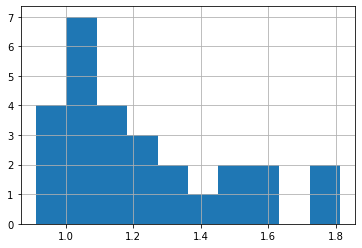

In [24]:
sub.iloc[1, 2:].hist(bins=10)

In [24]:
sub.id.nunique(), sub["id"].str.contains("validation$").sum()

(60980, 30490)

In [234]:
te_sub.head()

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.018831,1.085850,1.189012,1.169340,1.426008,1.774587,1.688131,1.563597,1.331529,1.270867,1.274395,1.483979,1.758404,1.470084,1.513911,1.481212,1.419783,1.388455,1.587009,2.061393,1.968799,1.485027,1.351374,1.396024,1.384555,1.668002,2.080933,2.061214
1,FOODS_1_001_CA_2_validation,1.538770,1.472487,1.425714,1.597200,1.926304,2.323259,2.352964,1.700500,1.632717,1.820182,1.736246,1.978333,2.436824,2.264255,1.800112,1.845100,1.853519,1.916247,2.402139,2.742208,2.701364,1.755606,1.756688,1.822756,1.980339,2.325873,2.825663,2.651688
2,FOODS_1_001_CA_3_validation,0.819569,1.149738,1.173926,1.187068,1.337940,1.927961,1.873218,1.423537,1.281470,1.325261,1.333951,1.587503,1.999089,1.581428,1.675824,1.589458,1.585713,1.617541,1.815334,2.209430,2.117456,1.595886,1.565532,1.596393,1.630212,1.926483,2.380595,2.254721
3,FOODS_1_001_CA_4_validation,0.561616,0.559683,0.577475,0.602783,0.646346,0.741425,0.705182,0.665209,0.656555,0.686229,0.661485,0.762644,0.851570,0.731437,0.687455,0.747978,0.765011,0.816230,0.840393,0.958794,0.905810,0.735737,0.726567,0.746687,0.765470,0.807503,0.916023,0.913137
4,FOODS_1_001_TX_1_validation,0.066212,0.669341,0.643111,0.667364,0.834586,0.912354,0.854693,0.726292,0.725802,0.692607,0.698147,0.742027,0.810038,0.655200,0.735004,0.706469,0.733638,0.784402,0.807454,0.876669,0.893081,0.689168,0.726796,0.744412,0.760446,0.813382,0.983308,0.940134


In [ ]:
# 予測値を丸める：0.01とかは0にできそう

In [ ]:
# 店・商品カテゴリごとにgroupby特徴量作れそう

In [ ]:
# WRMSSEをobjective funcにする

In [182]:
te.head()

,id,item_id,dept_id,store_id,cat_id,state_id,state_name,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,item_id_sales_mean,dept_id_sales_mean,cat_id_sales_mean,store_id_sales_mean,state_id_sales_mean
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,CA,d_1883,1.0,2016-03-25,11608,0,7,3,2016,0,0,0,0,0.0,0.0,0.0,8.26,0.405762,0.865234,0.708496,1.592773,1.525391
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,CA,d_1883,1.0,2016-03-25,11608,0,7,3,2016,0,0,0,0,0.0,0.0,0.0,3.97,0.274658,0.865234,0.708496,1.592773,1.525391
2,HOBBIES_1_003_CA_1_validation,2,0,0,0,0,CA,d_1883,1.0,2016-03-25,11608,0,7,3,2016,0,0,0,0,0.0,0.0,0.0,2.97,0.185425,0.865234,0.708496,1.592773,1.525391
3,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,CA,d_1883,0.0,2016-03-25,11608,0,7,3,2016,0,0,0,0,0.0,0.0,0.0,4.64,2.064453,0.865234,0.708496,1.592773,1.525391
4,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,CA,d_1883,0.0,2016-03-25,11608,0,7,3,2016,0,0,0,0,0.0,0.0,0.0,2.88,0.812012,0.865234,0.708496,1.592773,1.525391


In [187]:
te["sales"].value_counts()

0.000000    530270
1.000000    180701
2.000000     89195
3.000000     46660
4.000000     27905
             ...  
0.349969         1
7.528238         1
1.134912         1
0.747134         1
0.099411         1
Name: sales, Length: 853797, dtype: int64

In [86]:
%%time

# train_validation split
val_days = 30
n_folds = 1
dev_lastdate = datetime(2016,4, 24) 

for fold_idx in range(1, 1+n_folds, 1):
    print("*"*20)
    print(f"fold {fold_idx}...")
    print("*"*20)

    val_firstdate = dev_lastdate - timedelta(days=val_days*fold_idx)
    val_lastdate = dev_lastdate - timedelta(days=val_days*(fold_idx-1))
    train_lastdate = val_firstdate-timedelta(1)

    print("train period:", dev_firstdate.date(), "~", train_lastdate.date())
    print("validation period:", val_firstdate.date(), "~", val_lastdate.date())

    train_df = df.query("date < @val_firstdate")
    val_df = df.query("@val_lastdate >= date > @train_lastdate")

    print(min(train_df["date"]), max(train_df["date"]))
    print(min(val_df["date"]), max(val_df["date"]))

    train_df.tail()
    # fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
    # train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

    train_data = lgb.Dataset(train_df[train_cols], 
                             label = train_df["sales"], 
                             free_raw_data=False)
    val_data = lgb.Dataset(val_df[train_cols], 
                             label = val_df["sales"], 
                             free_raw_data=False)

    del train_df, val_df; gc.collect()

    m_lgb = lgb.train(params, 
                      train_data, 
                      valid_sets = [val_data], 
                      num_boost_round=2000,
                      early_stopping_rounds=300,
                      categorical_feature=cat_feats,
                      verbose_eval=100) 
    m_lgb.save_model(f"../result/fullmodel_fold{fold_idx}.lgb")

********************
fold 2...
********************
train period: 2011-01-30 ~ 2016-02-23
validation period: 2016-02-24 ~ 2016-03-25
2011-03-25 00:00:00 2016-02-23 00:00:00
2016-02-24 00:00:00 2016-03-25 00:00:00
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 1.92917
[200]	valid_0's rmse: 1.92463
[300]	valid_0's rmse: 1.92095
[400]	valid_0's rmse: 1.91821
[500]	valid_0's rmse: 1.9176
[600]	valid_0's rmse: 1.91669
[700]	valid_0's rmse: 1.91578
[800]	valid_0's rmse: 1.91548
[900]	valid_0's rmse: 1.91519
[1000]	valid_0's rmse: 1.91432
[1100]	valid_0's rmse: 1.91442
[1200]	valid_0's rmse: 1.91466
[1300]	valid_0's rmse: 1.91484
Early stopping, best iteration is:
[1033]	valid_0's rmse: 1.91425
********************
fold 3...
********************
train period: 2011-01-30 ~ 2016-01-24
validation period: 2016-01-25 ~ 2016-02-24
2011-03-25 00:00:00 2016-01-24 00:00:00
2016-01-25 00:00:00 2016-02-24 00:00:00
Training until validation scores don't improve for 30